In [1]:
#!pip3 install pandas
#!pip3 install sklearn
#!pip3 install seaborn
#!pip3 install matplotlib

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, cross_validate
from sklearn import tree, svm, preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_precision_recall_curve, f1_score, precision_score, recall_score, accuracy_score
from pandas import DataFrame, read_csv
import matplotlib.pyplot as plt
import numpy as np
import time
import statistics

# Classification Problem 1

## Get and clean the data

In [3]:
dataset = read_csv('diabetes.csv')
dataset.dropna(inplace=True)

## Display the data

array([[<AxesSubplot:title={'center':'Pregnancies'}>,
        <AxesSubplot:title={'center':'Glucose'}>,
        <AxesSubplot:title={'center':'BloodPressure'}>],
       [<AxesSubplot:title={'center':'SkinThickness'}>,
        <AxesSubplot:title={'center':'Insulin'}>,
        <AxesSubplot:title={'center':'BMI'}>],
       [<AxesSubplot:title={'center':'DiabetesPedigreeFunction'}>,
        <AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Outcome'}>]], dtype=object)

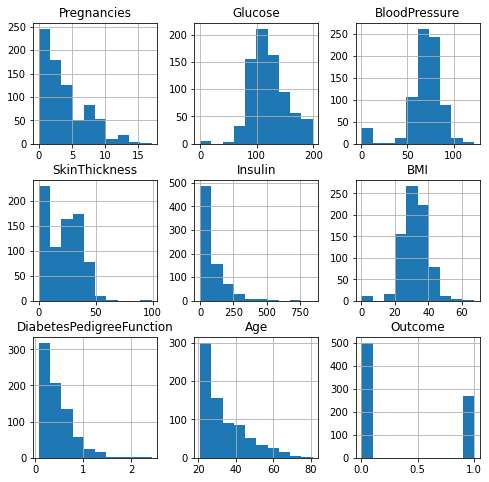

In [4]:
dataset.hist(figsize=(8,8))

## Preprocess tha data

In [5]:
dataset = dataset.loc[dataset.BloodPressure != 0,:]
dataset = dataset.loc[dataset.Glucose != 0,:]
dataset = dataset.loc[dataset.BMI != 0,:]

train_ds, test_ds = train_test_split(dataset, train_size=0.75, random_state=20, stratify=dataset['Outcome'])

y_train = train_ds.Outcome
X_train = train_ds.drop('Outcome', axis=1)
y_test = test_ds.Outcome
X_test = test_ds.drop('Outcome', axis=1)

scaler = preprocessing.StandardScaler().fit(X_train)
X_train = DataFrame(data=scaler.transform(X_train),columns=X_train.columns)
X_test = DataFrame(data=scaler.transform(X_test),columns=X_test.columns)

## Test Fonction

In [30]:
def LC(model_name, model, step=8, fit_per_step=2, average='binary'):
    n = X_train.shape[0]
    size = np.zeros(step)
    train_scores = np.zeros(step)
    test_scores = np.zeros(step)
    train_time = np.zeros(step)
    for e,i in enumerate(np.power(np.linspace(0.2,1.0,step),3)):
        X = X_train.head(round(i * n))
        y = y_train.head(round(i * n))
        size[e] = round(i * n)
        for _ in range(fit_per_step):
            t1 = time.time()
            model.fit(X,y)
            t2 = time.time()
            train_scores[e] += f1_score(model.predict(X),y, average=average)
            test_scores[e] += f1_score(model.predict(X_test),y_test, average=average)
            train_time[e] += t2-t1
        train_scores[e] /= fit_per_step
        test_scores[e] /= fit_per_step
        train_time /= fit_per_step
    plt.figure()
    plt.plot(size, train_scores, 'black', label='Training Score')
    plt.plot(size, test_scores, 'red', label='Testing Score')
    plt.title('Model: ' + str(model_name))
    plt.xlabel('Training Size')
    plt.ylabel('Score')
    plt.legend()
    plt.grid()
    plt.figure()
    plt.plot(size, train_time, 'blue')
    plt.title('Model: ' + str(model_name))
    plt.xlabel('Training Size')
    plt.ylabel('Fit time')
    plt.grid()

## Decision Tree

0 1 2 3 4 5 6 7 

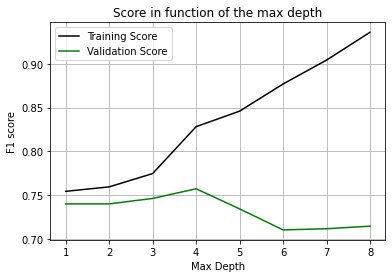

In [7]:
def select_decision_tree(step=X_train.columns.shape[0], fit_per_step=10, score='Precision', multiclass='binary'):
    train_scores = np.zeros(step)
    val_scores = np.zeros(step)
    for i in range(step):
        print(i, end=' ')
        for _ in range(fit_per_step):
            DTC = tree.DecisionTreeClassifier(max_depth=i+1)
            cross_val = cross_validate(DTC, X_train, y_train, cv=5, scoring='f1_micro', return_train_score=True)
            if score == 'Precision':
                train_scores[i] += precision_score(DTC.predict(X_train), y_train) #DTC.score(X_train,y_train)
                test_scores[i] += precision_score(DTC.predict(X_test), y_test) #DTC.score(X_test, y_test) 
            if score == 'Recall':
                train_scores[i] += recall_score(DTC.predict(X_train), y_train) #DTC.score(X_train,y_train)
                test_scores[i] += recall_score(DTC.predict(X_test), y_test) #DTC.score(X_test, y_test) 
            else:
                train_scores[i] += statistics.mean(cross_val['train_score'])
                val_scores[i] += statistics.mean(cross_val['test_score']) 
        train_scores[i] /= fit_per_step
        val_scores[i] /= fit_per_step
    plt.figure()
    plt.plot(range(1,step+1), train_scores, 'black', label='Training Score')
    plt.plot(range(1,step+1), val_scores, 'green', label='Validation Score')
    plt.title('Score in function of the max depth')
    plt.xlabel('Max Depth')
    plt.ylabel(score+' score')
    plt.legend()
    plt.grid()
select_decision_tree(score='F1', multiclass='micro')

[Text(315.1666666666667, 489.24, 'Glucose <= 1.047\n543\n[356, 187]'),
 Text(165.33333333333334, 380.52000000000004, 'Age <= -0.442\n454\n[338, 116]'),
 Text(82.66666666666667, 271.8, 'BMI <= 1.882\n220\n[194, 26]'),
 Text(41.333333333333336, 163.08000000000004, 'BMI <= -0.215\n216\n[193, 23]'),
 Text(20.666666666666668, 54.360000000000014, '109\n[105, 4]'),
 Text(62.0, 54.360000000000014, '107\n[88, 19]'),
 Text(124.0, 163.08000000000004, 'Pregnancies <= 0.017\n4\n[1, 3]'),
 Text(103.33333333333334, 54.360000000000014, '3\n[0, 3]'),
 Text(144.66666666666669, 54.360000000000014, '1\n[1, 0]'),
 Text(248.0, 271.8, 'BMI <= -0.832\n234\n[144, 90]'),
 Text(206.66666666666669, 163.08000000000004, 'Age <= 2.106\n41\n[40, 1]'),
 Text(186.0, 54.360000000000014, '35\n[35, 0]'),
 Text(227.33333333333334, 54.360000000000014, '6\n[5, 1]'),
 Text(289.33333333333337, 163.08000000000004, 'Glucose <= -0.381\n193\n[104, 89]'),
 Text(268.6666666666667, 54.360000000000014, '73\n[56, 17]'),
 Text(310.0, 54

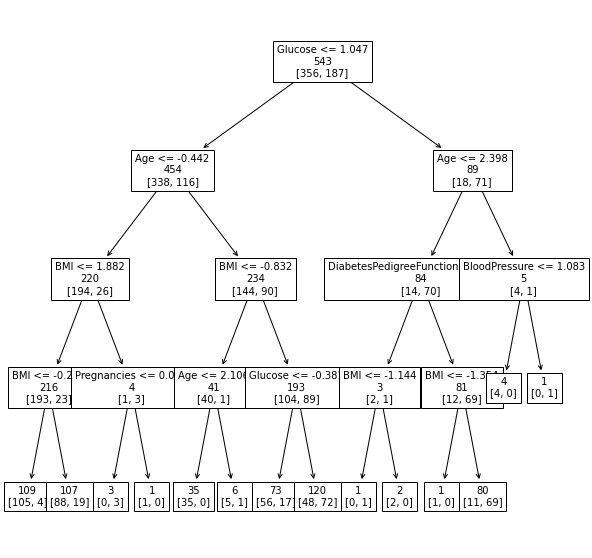

In [8]:
DTC = tree.DecisionTreeClassifier(max_depth=4)
DTC.fit(X_train,y_train)
plt.figure(figsize=(10,10))
tree.plot_tree(DTC, impurity=False, label=None, feature_names=dataset.columns, fontsize=10)

<Figure size 432x288 with 0 Axes>

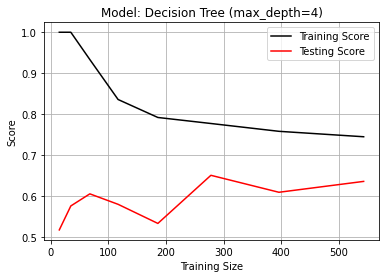

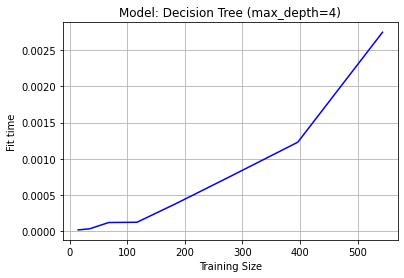

In [9]:
plt.figure()
DTC = tree.DecisionTreeClassifier(max_depth=4)
LC('Decision Tree (max_depth=4)', DTC)

## Random Forest

0 1 2 3 4 5 6 7 

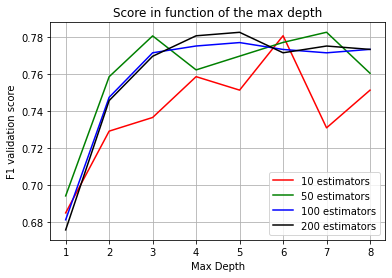

In [12]:
def select_random_forest(step=X_train.columns.shape[0], fit_per_step=1, multiclass='binary'):
    val_scores = np.zeros(step)
    val_scores2 = np.zeros(step)
    val_scores3 = np.zeros(step)
    val_scores4 = np.zeros(step)
    for i in range(step):
        print(i, end=' ')
        for _ in range(fit_per_step):
            RFC = RandomForestClassifier(n_estimators=10, max_depth=i+1)
            cross_val = cross_validate(RFC, X_train, y_train, cv=5, scoring='f1_micro')
            val_scores[i] += statistics.mean(cross_val['test_score']) 
            RFC = RandomForestClassifier(n_estimators=50, max_depth=i+1)
            cross_val = cross_validate(RFC, X_train, y_train, cv=5, scoring='f1_micro')
            val_scores2[i] += statistics.mean(cross_val['test_score'])
            RFC = RandomForestClassifier(n_estimators=100, max_depth=i+1)
            cross_val = cross_validate(RFC, X_train, y_train, cv=5, scoring='f1_micro')
            val_scores3[i] += statistics.mean(cross_val['test_score'])
            RFC = RandomForestClassifier(n_estimators=100, max_depth=i+1)
            cross_val = cross_validate(RFC, X_train, y_train, cv=5, scoring='f1_micro')
            val_scores4[i] += statistics.mean(cross_val['test_score'])
        val_scores[i] /= fit_per_step
        val_scores2[i] /= fit_per_step
        val_scores3[i] /= fit_per_step
        val_scores4[i] /= fit_per_step
    plt.figure()
    plt.plot(range(1,step+1), val_scores, 'red', label='10 estimators')
    plt.plot(range(1,step+1), val_scores2, 'green', label='50 estimators')
    plt.plot(range(1,step+1), val_scores3, 'blue', label='100 estimators')
    plt.plot(range(1,step+1), val_scores4, 'black', label='200 estimators')
    plt.title('Score in function of the max depth')
    plt.xlabel('Max Depth')
    plt.ylabel('F1 validation score')
    plt.legend()
    plt.grid()
select_random_forest()

<Figure size 432x288 with 0 Axes>

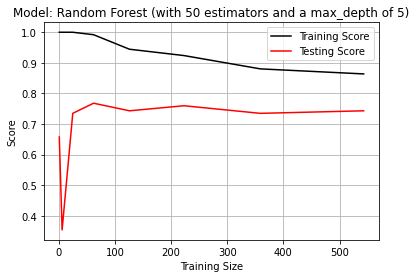

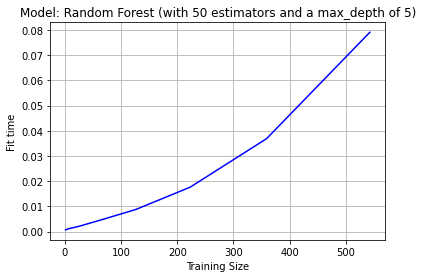

In [15]:
plt.figure()
RFC = RandomForestClassifier(n_estimators=50, max_depth=5)
LC('Random Forest (with 50 estimators and a max_depth of 5)', RFC, average='micro')

## k-Nearest Neighbors

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

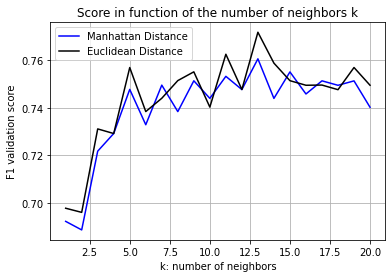

In [16]:
def select_knn(step=20, fit_per_step=2, score='', average='binary'):
    val_scores = np.zeros(step)
    val_scores2 = np.zeros(step)
    for i in range(step):
        print(i, end=' ')
        for _ in range(fit_per_step):
            KNN = KNeighborsClassifier(n_neighbors=i+1, metric='manhattan')
            cross_val = cross_validate(KNN, X_train, y_train, cv=5, scoring='f1_micro', return_train_score=True)
            val_scores[i] += statistics.mean(cross_val['test_score']) 
            KNN = KNeighborsClassifier(n_neighbors=i+1, metric='euclidean')
            cross_val = cross_validate(KNN, X_train, y_train, cv=5, scoring='f1_micro', return_train_score=True)
            val_scores2[i] += statistics.mean(cross_val['test_score']) 
        val_scores[i] /= fit_per_step
        val_scores2[i] /= fit_per_step
    plt.figure()
    plt.plot(range(1,step+1), val_scores, 'blue', label='Manhattan Distance')
    plt.plot(range(1,step+1), val_scores2, 'black', label='Euclidean Distance')
    plt.title('Score in function of the number of neighbors k')
    plt.xlabel('k: number of neighbors')
    plt.ylabel('F1 validation score')
    plt.legend()
    plt.grid()
select_knn()

<Figure size 432x288 with 0 Axes>

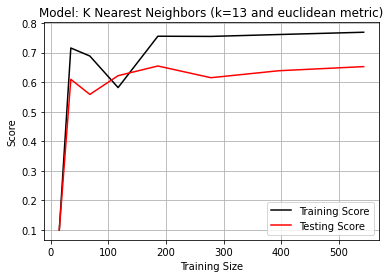

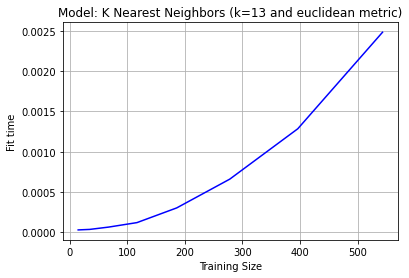

In [24]:
plt.figure()
KNN = KNeighborsClassifier(n_neighbors=13, metric='euclidean')
LC('K Nearest Neighbors (k=13 and euclidean metric)', KNN)

## Support Vector Machines

### Polynomial Kernel

0 1 2 3 4 5 6 7 

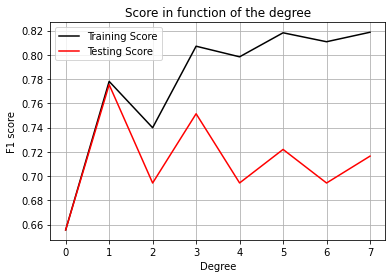

In [26]:
def select_polynomial_SVM(step=7, fit_per_step=10, average='binary'):
    train_scores = np.zeros(step+1)
    val_scores = np.zeros(step+1)
    for d in range(step+1):
        print(d, end=' ')
        for _ in range(fit_per_step):
            SVM = svm.SVC(kernel='poly', degree=d)
            cross_val = cross_validate(SVM, X_train, y_train, cv=5, scoring='f1_micro', return_train_score=True)
            train_scores[d] += statistics.mean(cross_val['train_score'])
            val_scores[d] += statistics.mean(cross_val['test_score'])
        train_scores[d] /= fit_per_step
        val_scores[d] /= fit_per_step
    plt.figure()
    plt.plot(range(step+1), train_scores, 'black', label='Training Score')
    plt.plot(range(step+1), val_scores, 'red', label='Testing Score')
    plt.title('Score in function of the degree')
    plt.xlabel('Degree')
    plt.ylabel('F1 score')
    plt.legend()
    plt.grid()
select_polynomial_SVM(average='binary')

<Figure size 432x288 with 0 Axes>

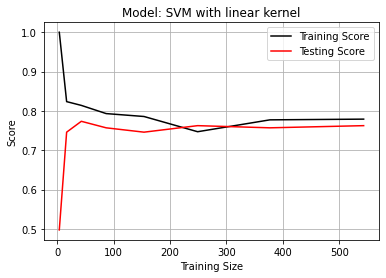

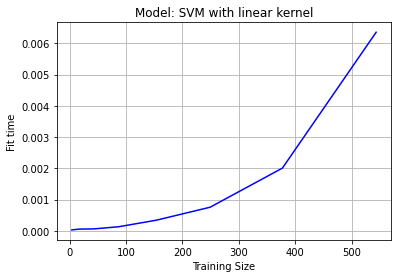

In [31]:
plt.figure()
SVM = svm.SVC(kernel='poly', degree=1)
LC('SVM with linear kernel', SVM, average='micro')

### RBF Kernel

1e-05 0.0001 0.001 0.01 0.1 1 10 100 1000 10000 100000 

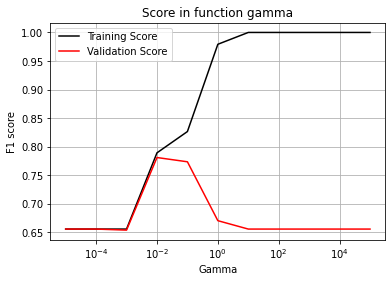

In [32]:
def select_rbf_SVM(step=7, fit_per_step=10, average='binary'):
    gammas = list(map(lambda x: 10**x, range(-5,6)))
    train_scores = np.zeros(len(gammas))
    val_scores = np.zeros(len(gammas))
    for i,gamma in enumerate(gammas):
        print(gamma, end=' ')
        for _ in range(fit_per_step):
            SVM = svm.SVC(kernel='rbf', gamma=gamma)
            cross_val = cross_validate(SVM, X_train, y_train, cv=5, scoring='f1_micro', return_train_score=True)
            train_scores[i] += statistics.mean(cross_val['train_score'])
            val_scores[i] += statistics.mean(cross_val['test_score'])
        train_scores[i] /= fit_per_step
        val_scores[i] /= fit_per_step
    plt.figure()
    plt.semilogx(gammas, train_scores, 'black', label='Training Score')
    plt.semilogx(gammas, val_scores, 'red', label='Validation Score')
    plt.title('Score in function gamma')
    plt.xlabel('Gamma')
    plt.ylabel('F1 score')
    plt.legend()
    plt.grid()
select_rbf_SVM(average='binary')

<Figure size 432x288 with 0 Axes>

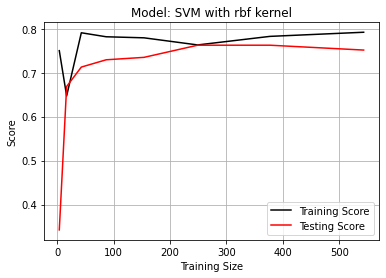

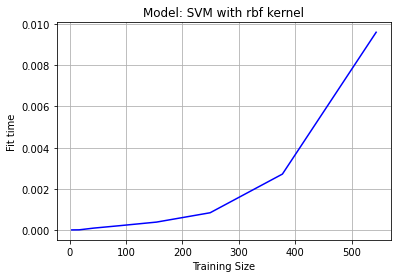

In [33]:
plt.figure()
SVM = svm.SVC(kernel='rbf', gamma=0.01)
LC('SVM with rbf kernel', SVM, average='micro')

## Neural Network

0 1 2 3 4 5 

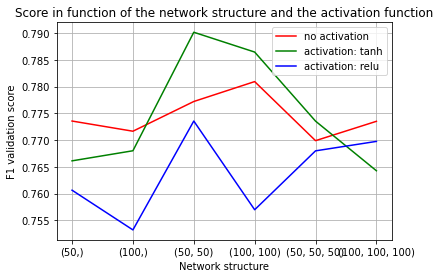

In [34]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
def select_neural_network(structures=[(50,),(100,),(50,50,),(100,100,), (50, 50, 50), (100,100,100)], fit_per_step=1, multiclass='binary'):
    val_scores = np.zeros(len(structures))
    val_scores2 = np.zeros(len(structures))
    val_scores3 = np.zeros(len(structures))
    for i, structure in enumerate(structures):
        print(i, end=' ')
        for _ in range(fit_per_step):
            NN = MLPClassifier(hidden_layer_sizes=structure, learning_rate_init=0.01 if len(structure)==1 else 0.001, activation='identity', max_iter=60)
            cross_val = cross_validate(NN, X_train, y_train, cv=5, scoring='f1_micro')
            val_scores[i] += statistics.mean(cross_val['test_score']) 
            NN = MLPClassifier(hidden_layer_sizes=structure, learning_rate_init=0.01 if len(structure)==1 else 0.001, activation='tanh', max_iter=60)
            cross_val = cross_validate(NN, X_train, y_train, cv=5, scoring='f1_micro')
            val_scores2[i] += statistics.mean(cross_val['test_score'])
            NN = MLPClassifier(hidden_layer_sizes=structure, learning_rate_init=0.01 if len(structure)==1 else 0.001, activation='relu', max_iter=60)
            cross_val = cross_validate(NN, X_train, y_train, cv=5, scoring='f1_micro')
            val_scores3[i] += statistics.mean(cross_val['test_score'])
        val_scores[i] /= fit_per_step
        val_scores2[i] /= fit_per_step
        val_scores3[i] /= fit_per_step
    plt.figure()
    plt.plot([str(s) for s in structures], val_scores, 'red', label='no activation')
    plt.plot([str(s) for s in structures], val_scores2, 'green', label='activation: tanh')
    plt.plot([str(s) for s in structures], val_scores3, 'blue', label='activation: relu')
    plt.title('Score in function of the network structure and the activation function')
    plt.xlabel('Network structure')
    plt.ylabel('F1 validation score')
    plt.legend()
    plt.grid()
select_neural_network(multiclass='binary')

1 2 3 5 8 11 14 18 22 27 32 38 44 51 58 65 73 81 90 100 

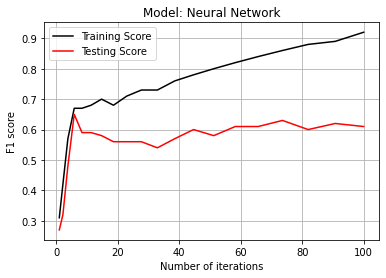

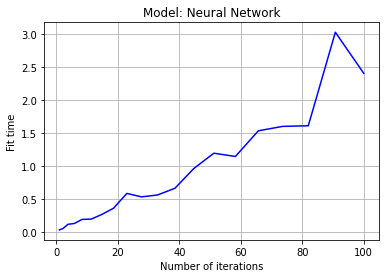

In [38]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
n = 20
I = 100*(np.linspace(0.1,1,n))**2
train_time = np.zeros(n)
train_score = np.zeros(n)
val_score = np.zeros(n)
for c,i in enumerate(I):
    print(int(i), end=' ')
    NN = MLPClassifier(hidden_layer_sizes=(200, 200), learning_rate_init=0.001, activation='relu', max_iter=int(i))
    t1 = time.time()
    NN.fit(X_train,y_train)
    t2 = time.time()
    train_time[c] = t2-t1
    train_score[c] = round(f1_score(NN.predict(X_train),y_train, average='binary'),2)
    val_score[c] = round(f1_score(NN.predict(X_test),y_test, average='binary'),2)
plt.figure()
plt.plot(I, train_score, 'black', label='Training Score')
plt.plot(I, val_score, 'red', label='Testing Score')
plt.title('Model: Neural Network')
plt.xlabel('Number of iterations')
plt.ylabel('F1 score')
plt.legend()
plt.grid()

plt.figure()
plt.plot(I, train_time, 'blue')
plt.title('Model: Neural Network')
plt.xlabel('Number of iterations')
plt.ylabel('Fit time')
plt.grid()

In [61]:
DTC = tree.DecisionTreeClassifier(max_depth=4)
RFC = RandomForestClassifier(n_estimators=50, max_depth=5)
KNN = KNeighborsClassifier(n_neighbors=13, metric='euclidean')
SVM1 = svm.SVC(kernel='poly', degree=1)
SVM2 = svm.SVC(kernel='rbf', gamma=0.01)
NN = MLPClassifier(hidden_layer_sizes=(50, 50), learning_rate_init=0.001, activation='tanh', max_iter=100)
models = [DTC,RFC,KNN,SVM1,SVM2,NN]

In [64]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
for model in models:
    print(model)
    t1 = time.time()
    model.fit(X_train,y_train)
    t2 = time.time()
    prediction = model.predict(X_test)
    t3 = time.time()
    print('fit time: ', round(1000*(t2-t1),3) , ' - prediction time: ', round(1000*(t3-t2), 3))
    print('f1 score: ', round(f1_score(model.predict(X_test),y_test),2))

DecisionTreeClassifier(max_depth=4)
fit time:  3.972  - prediction time:  2.474
f1 score:  0.62
RandomForestClassifier(max_depth=5, n_estimators=50)
fit time:  98.664  - prediction time:  7.118
f1 score:  0.59
KNeighborsClassifier(metric='euclidean', n_neighbors=13)
fit time:  3.144  - prediction time:  10.543
f1 score:  0.55
SVC(degree=1, kernel='poly')
fit time:  7.038  - prediction time:  2.413
f1 score:  0.6
SVC(gamma=0.01)
fit time:  9.303  - prediction time:  3.508
f1 score:  0.58
MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 50), max_iter=100)
fit time:  1092.418  - prediction time:  4.398
f1 score:  0.6


# Classification Problem 2

### Get and clean the data

In [3]:
dataset = read_csv('winequality-white.csv', sep=';')
dataset.dropna(inplace=True)
dataset.loc[dataset.quality < 6,'quality'] = 0
dataset.loc[dataset.quality == 6,'quality'] = 1
dataset.loc[dataset.quality > 6,'quality'] = 2
dataset.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,0.881584
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.733030
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,0.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,0.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,1.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,1.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,2.000000


### Display the data

array([[<AxesSubplot:title={'center':'fixed acidity'}>,
        <AxesSubplot:title={'center':'volatile acidity'}>,
        <AxesSubplot:title={'center':'citric acid'}>],
       [<AxesSubplot:title={'center':'residual sugar'}>,
        <AxesSubplot:title={'center':'chlorides'}>,
        <AxesSubplot:title={'center':'free sulfur dioxide'}>],
       [<AxesSubplot:title={'center':'total sulfur dioxide'}>,
        <AxesSubplot:title={'center':'density'}>,
        <AxesSubplot:title={'center':'pH'}>],
       [<AxesSubplot:title={'center':'sulphates'}>,
        <AxesSubplot:title={'center':'alcohol'}>,
        <AxesSubplot:title={'center':'quality'}>]], dtype=object)

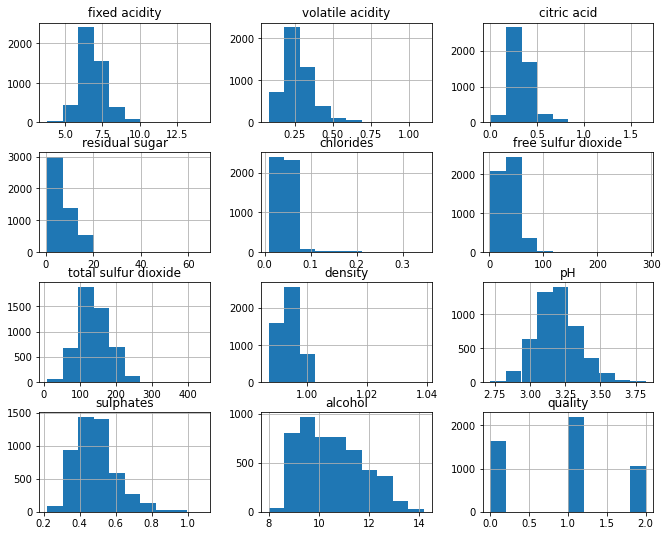

In [4]:
dataset.hist(figsize=(11,9))

### Preprocess the data

In [5]:
train_ds, test_ds = train_test_split(dataset, train_size=0.75, random_state=0, stratify=dataset['quality'])

y_train = train_ds.loc[:,'quality']
X_train = train_ds.drop('quality', axis=1)
y_test = test_ds.loc[:,'quality']
X_test = test_ds.drop('quality', axis=1)

scaler = preprocessing.StandardScaler().fit(X_train)
X_train = DataFrame(data=scaler.transform(X_train),columns=X_train.columns)
X_test = DataFrame(data=scaler.transform(X_test),columns=X_test.columns)

## Test Fonction

In [7]:
def LC(model_name, model, step=8, fit_per_step=2, average='binary'):
    model_saved = model
    n = X_train.shape[0]
    size = np.zeros(step)
    train_scores = np.zeros(step)
    test_scores = np.zeros(step)
    train_time = np.zeros(step)
    for e,i in enumerate(np.power(np.linspace(0.4,1.0,step),3)):
        X = X_train.head(round(i * n))
        y = y_train.head(round(i * n))
        size[e] = round(i * n)
        for _ in range(fit_per_step):
            t1 = time.time()
            model = model_saved
            model.fit(X,y)
            t2 = time.time()
            train_scores[e] += f1_score(model.predict(X),y, average=average)
            test_scores[e] += f1_score(model.predict(X_test),y_test, average=average)
            train_time[e] += t2-t1
        train_scores[e] /= fit_per_step
        test_scores[e] /= fit_per_step
        train_time /= fit_per_step
    plt.figure()
    plt.plot(size, train_scores, 'black', label='Training Score')
    plt.plot(size, test_scores, 'red', label='Testing Score')
    plt.title('Model: ' + str(model_name))
    plt.xlabel('Training Size')
    plt.ylabel('F1 score')
    plt.legend()
    plt.grid()
    plt.figure()
    plt.plot(size, train_time, 'blue')
    plt.title('Model: ' + str(model_name))
    plt.xlabel('Training Size')
    plt.ylabel('Fit time')
    plt.grid()

## Decision Tree

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

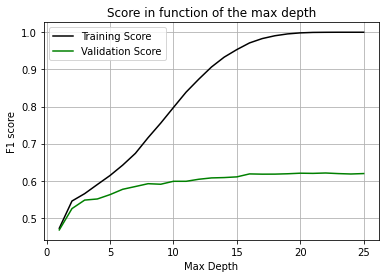

In [7]:
def select_decision_tree(step=25, fit_per_step=10, score='Precision', multiclass='binary'):
    train_scores = np.zeros(step)
    val_scores = np.zeros(step)
    for i in range(step):
        print(i, end=' ')
        for _ in range(fit_per_step):
            DTC = tree.DecisionTreeClassifier(max_depth=i+1)
            cross_val = cross_validate(DTC, X_train, y_train, cv=5, scoring='f1_micro', return_train_score=True)
            if score == 'Precision':
                train_scores[i] += precision_score(DTC.predict(X_train), y_train) #DTC.score(X_train,y_train)
                test_scores[i] += precision_score(DTC.predict(X_test), y_test) #DTC.score(X_test, y_test) 
            if score == 'Recall':
                train_scores[i] += recall_score(DTC.predict(X_train), y_train) #DTC.score(X_train,y_train)
                test_scores[i] += recall_score(DTC.predict(X_test), y_test) #DTC.score(X_test, y_test) 
            else:
                train_scores[i] += statistics.mean(cross_val['train_score'])
                val_scores[i] += statistics.mean(cross_val['test_score']) 
        train_scores[i] /= fit_per_step
        val_scores[i] /= fit_per_step
    plt.figure()
    plt.plot(range(1,step+1), train_scores, 'black', label='Training Score')
    plt.plot(range(1,step+1), val_scores, 'green', label='Validation Score')
    plt.title('Score in function of the max depth')
    plt.xlabel('Max Depth')
    plt.ylabel('F1 score')
    plt.legend()
    plt.grid()
select_decision_tree(score='F1', multiclass='micro')

[Text(279.0, 489.24, 'alcohol <= 0.274\n3673\n[1230, 1648, 795]'),
 Text(139.5, 380.52000000000004, 'volatile acidity <= 0.095\n2315\n[1073, 1004, 238]'),
 Text(69.75, 271.8, 'volatile acidity <= -0.713\n1477\n[509, 748, 220]'),
 Text(34.875, 163.08000000000004, 'alcohol <= -1.192\n542\n[113, 301, 128]'),
 Text(17.4375, 54.360000000000014, '\n  (...)  \n'),
 Text(52.3125, 54.360000000000014, '\n  (...)  \n'),
 Text(104.625, 163.08000000000004, 'alcohol <= -0.54\n935\n[396, 447, 92]'),
 Text(87.1875, 54.360000000000014, '\n  (...)  \n'),
 Text(122.0625, 54.360000000000014, '\n  (...)  \n'),
 Text(209.25, 271.8, 'alcohol <= -0.622\n838\n[564, 256, 18]'),
 Text(174.375, 163.08000000000004, 'density <= 2.468\n530\n[400, 123, 7]'),
 Text(156.9375, 54.360000000000014, '\n  (...)  \n'),
 Text(191.8125, 54.360000000000014, '\n  (...)  \n'),
 Text(244.125, 163.08000000000004, 'free sulfur dioxide <= -0.882\n308\n[164, 133, 11]'),
 Text(226.6875, 54.360000000000014, '\n  (...)  \n'),
 Text(261.5

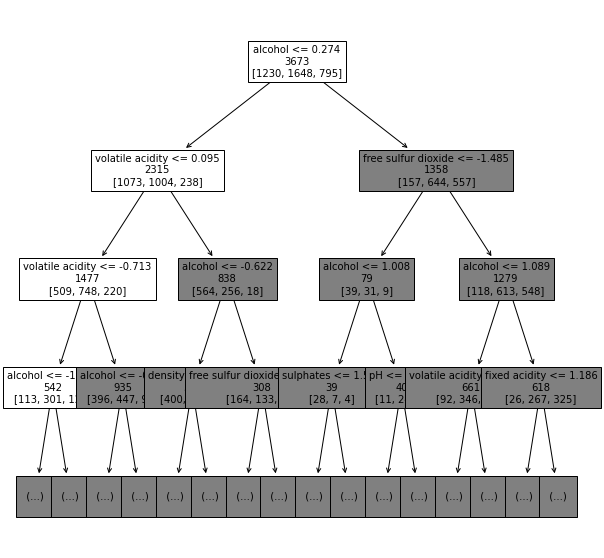

In [8]:
DTC = tree.DecisionTreeClassifier(max_depth=17)
DTC.fit(X_train,y_train)
plt.figure(figsize=(10,10))
tree.plot_tree(DTC, max_depth=3, impurity=False, label=None, feature_names=dataset.columns, fontsize=10)

<Figure size 432x288 with 0 Axes>

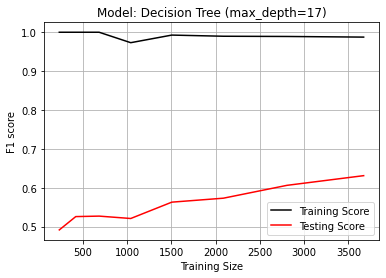

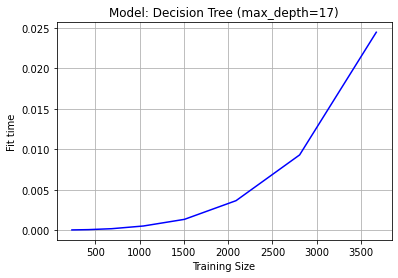

In [9]:
plt.figure()
DTC = tree.DecisionTreeClassifier(max_depth=17)
LC('Decision Tree (max_depth=17)', DTC, average='micro')

## Random Forest

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

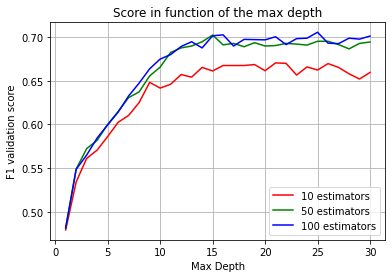

In [10]:
def select_random_forest(step=30, fit_per_step=1, multiclass='binary'):
    val_scores = np.zeros(step)
    val_scores2 = np.zeros(step)
    val_scores3 = np.zeros(step)
    for i in range(step):
        print(i, end=' ')
        for _ in range(fit_per_step):
            RFC = RandomForestClassifier(n_estimators=10, max_depth=i+1)
            cross_val = cross_validate(RFC, X_train, y_train, cv=5, scoring='f1_micro')
            val_scores[i] += statistics.mean(cross_val['test_score']) 
            RFC = RandomForestClassifier(n_estimators=50, max_depth=i+1)
            cross_val = cross_validate(RFC, X_train, y_train, cv=5, scoring='f1_micro')
            val_scores2[i] += statistics.mean(cross_val['test_score'])
            RFC = RandomForestClassifier(n_estimators=100, max_depth=i+1)
            cross_val = cross_validate(RFC, X_train, y_train, cv=5, scoring='f1_micro')
            val_scores3[i] += statistics.mean(cross_val['test_score'])
        val_scores[i] /= fit_per_step
        val_scores2[i] /= fit_per_step
        val_scores3[i] /= fit_per_step
    plt.figure()
    plt.plot(range(1,step+1), val_scores, 'red', label='10 estimators')
    plt.plot(range(1,step+1), val_scores2, 'green', label='50 estimators')
    plt.plot(range(1,step+1), val_scores3, 'blue', label='100 estimators')
    plt.title('Score in function of the max depth')
    plt.xlabel('Max Depth')
    plt.ylabel('F1 validation score')
    plt.legend()
    plt.grid()
select_random_forest(multiclass='micro')

<Figure size 432x288 with 0 Axes>

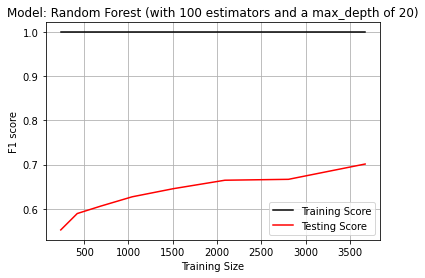

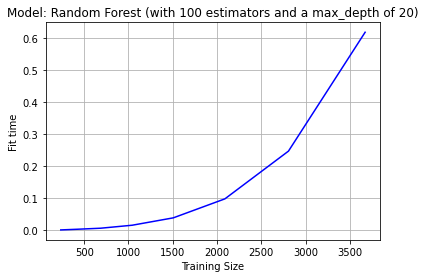

In [11]:
plt.figure()
RFC = RandomForestClassifier(n_estimators=100, max_depth=20)
LC('Random Forest (with 100 estimators and a max_depth of 20)', RFC, average='micro')

## KNN

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

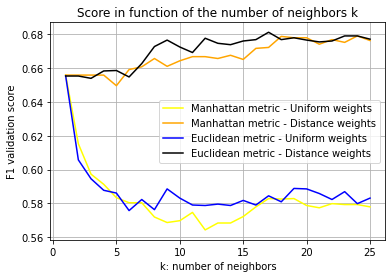

In [20]:
def select_knn(step=25, fit_per_step=1, score='', average='binary'):
    val_scores = np.zeros(step)
    val_scores2 = np.zeros(step)
    val_scores3 = np.zeros(step)
    val_scores4 = np.zeros(step)
    for i in range(step):
        print(i, end=' ')
        for _ in range(fit_per_step):
            KNN = KNeighborsClassifier(n_neighbors=i+1, metric='manhattan')
            cross_val = cross_validate(KNN, X_train, y_train, cv=5, scoring='f1_micro', return_train_score=True)
            val_scores[i] += statistics.mean(cross_val['test_score'])
            KNN = KNeighborsClassifier(n_neighbors=i+1, metric='manhattan', weights='distance')
            cross_val = cross_validate(KNN, X_train, y_train, cv=5, scoring='f1_micro', return_train_score=True)
            val_scores2[i] += statistics.mean(cross_val['test_score']) 
            KNN = KNeighborsClassifier(n_neighbors=i+1, metric='euclidean')
            cross_val = cross_validate(KNN, X_train, y_train, cv=5, scoring='f1_micro', return_train_score=True)
            val_scores3[i] += statistics.mean(cross_val['test_score'])
            KNN = KNeighborsClassifier(n_neighbors=i+1, metric='euclidean', weights='distance')
            cross_val = cross_validate(KNN, X_train, y_train, cv=5, scoring='f1_micro', return_train_score=True)
            val_scores4[i] += statistics.mean(cross_val['test_score']) 
        val_scores[i] /= fit_per_step
        val_scores2[i] /= fit_per_step
        val_scores3[i] /= fit_per_step
        val_scores4[i] /= fit_per_step
    plt.figure()
    plt.plot(range(1,step+1), val_scores, 'yellow', label='Manhattan metric - Uniform weights')
    plt.plot(range(1,step+1), val_scores2, 'orange', label='Manhattan metric - Distance weights')
    plt.plot(range(1,step+1), val_scores3, 'blue', label='Euclidean metric - Uniform weights')
    plt.plot(range(1,step+1), val_scores4, 'black', label='Euclidean metric - Distance weights')
    plt.title('Score in function of the number of neighbors k')
    plt.xlabel('k: number of neighbors')
    plt.ylabel('F1 validation score')
    plt.legend()
    plt.grid()
select_knn()

<Figure size 432x288 with 0 Axes>

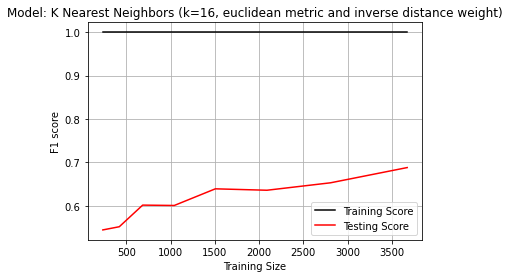

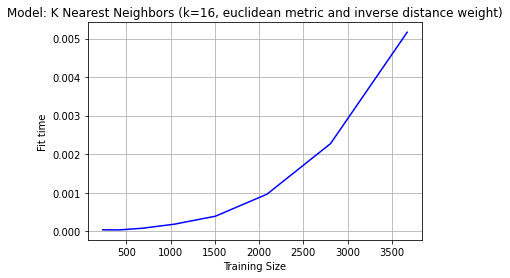

In [25]:
plt.figure()
KNN = KNeighborsClassifier(n_neighbors=16, weights='distance', metric='euclidean')
LC('K Nearest Neighbors (k=16, euclidean metric and inverse distance weight)', KNN, average='micro')

## Support Vector Machines

### Polynomial Kernel

0 1 2 3 4 5 6 7 

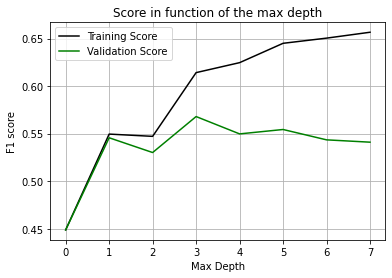

In [12]:
def select_polynomial_SVM(step=7, fit_per_step=1, average='binary'):
    train_scores = np.zeros(step+1)
    val_scores = np.zeros(step+1)
    for d in range(step+1):
        print(d, end=' ')
        for _ in range(fit_per_step):
            SVM = svm.SVC(kernel='poly', degree=d)
            cross_val = cross_validate(SVM, X_train, y_train, cv=5, scoring='f1_micro', return_train_score=True)
            train_scores[d] += statistics.mean(cross_val['train_score'])
            val_scores[d] += statistics.mean(cross_val['test_score'])
        train_scores[d] /= fit_per_step
        val_scores[d] /= fit_per_step
    plt.figure()
    plt.plot(range(step+1), train_scores, 'black', label='Training Score')
    plt.plot(range(step+1), val_scores, 'green', label='Validation Score')
    plt.title('Score in function of the max depth')
    plt.xlabel('Max Depth')
    plt.ylabel('F1 score')
    plt.legend()
    plt.grid()
select_polynomial_SVM(average='micro')

<Figure size 432x288 with 0 Axes>

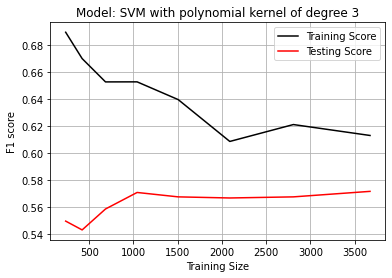

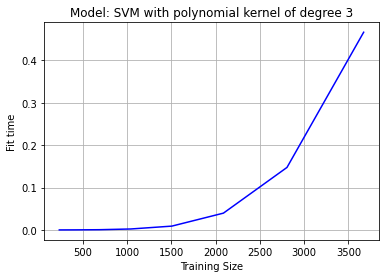

In [47]:
plt.figure()
SVM = svm.SVC(kernel='poly', degree=3)
LC('SVM with polynomial kernel of degree 3', SVM, average='micro')

### RBF Kernel

1e-05 0.0001 0.001 0.01 0.1 1 10 100 1000 10000 100000 

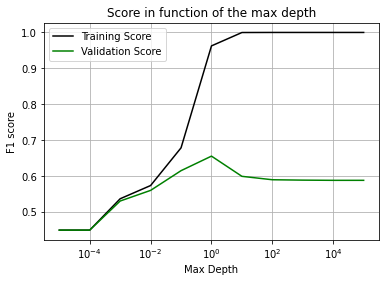

In [43]:
def select_rbf_SVM(step=7, fit_per_step=1, average='binary'):
    gammas = list(map(lambda x: 10**x, range(-5,6)))
    train_scores = np.zeros(len(gammas))
    val_scores = np.zeros(len(gammas))
    for i,gamma in enumerate(gammas):
        print(gamma, end=' ')
        for _ in range(fit_per_step):
            SVM = svm.SVC(kernel='rbf', gamma=gamma)
            cross_val = cross_validate(SVM, X_train, y_train, cv=5, scoring='f1_micro', return_train_score=True)
            train_scores[i] += statistics.mean(cross_val['train_score'])
            val_scores[i] += statistics.mean(cross_val['test_score'])
        train_scores[i] /= fit_per_step
        val_scores[i] /= fit_per_step
    plt.figure()
    plt.semilogx(gammas, train_scores, 'black', label='Training Score')
    plt.semilogx(gammas, val_scores, 'green', label='Validation Score')
    plt.title('Score in function of the max depth')
    plt.xlabel('Max Depth')
    plt.ylabel('F1 score')
    plt.legend()
    plt.grid()
select_rbf_SVM(average='micro')

<Figure size 432x288 with 0 Axes>

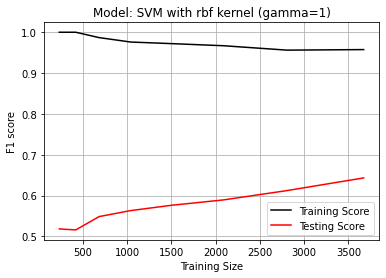

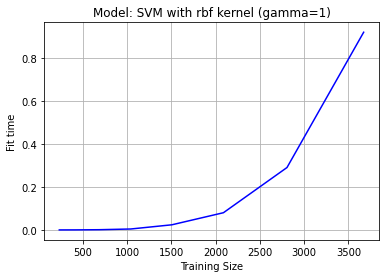

In [48]:
plt.figure()
SVM = svm.SVC(kernel='rbf', gamma=1)
LC('SVM with rbf kernel (gamma=1)', SVM, average='micro')

## Neural Network

0 1 2 3 

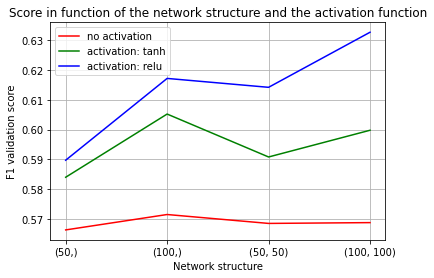

In [8]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
def select_neural_network(structures=[(50,),(100,),(50,50,),(100,100,), (50, 50, 50), (100,100,100)], fit_per_step=1, multiclass='binary'):
    val_scores = np.zeros(len(structures))
    val_scores2 = np.zeros(len(structures))
    val_scores3 = np.zeros(len(structures))
    for i, structure in enumerate(structures):
        print(i, end=' ')
        for _ in range(fit_per_step):
            NN = MLPClassifier(hidden_layer_sizes=structure, learning_rate_init=0.01 if len(structure)==1 else 0.001, activation='identity', max_iter=60)
            cross_val = cross_validate(NN, X_train, y_train, cv=5, scoring='f1_micro')
            val_scores[i] += statistics.mean(cross_val['test_score']) 
            NN = MLPClassifier(hidden_layer_sizes=structure, learning_rate_init=0.01 if len(structure)==1 else 0.001, activation='tanh', max_iter=60)
            cross_val = cross_validate(NN, X_train, y_train, cv=5, scoring='f1_micro')
            val_scores2[i] += statistics.mean(cross_val['test_score'])
            NN = MLPClassifier(hidden_layer_sizes=structure, learning_rate_init=0.01 if len(structure)==1 else 0.001, activation='relu', max_iter=60)
            cross_val = cross_validate(NN, X_train, y_train, cv=5, scoring='f1_micro')
            val_scores3[i] += statistics.mean(cross_val['test_score'])
        val_scores[i] /= fit_per_step
        val_scores2[i] /= fit_per_step
        val_scores3[i] /= fit_per_step
    plt.figure()
    plt.plot([str(s) for s in structures], val_scores, 'red', label='no activation')
    plt.plot([str(s) for s in structures], val_scores2, 'green', label='activation: tanh')
    plt.plot([str(s) for s in structures], val_scores3, 'blue', label='activation: relu')
    plt.title('Score in function of the network structure and the activation function')
    plt.xlabel('Network structure')
    plt.ylabel('F1 validation score')
    plt.legend()
    plt.grid()
select_neural_network(multiclass='micro')

0 1 2 3 4 

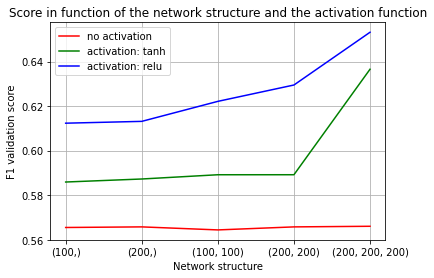

In [14]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
def select_neural_network(structures=[(100,),(200,),(100,100,),(200,200,), (200,200,200)], fit_per_step=1, multiclass='binary'):
    val_scores = np.zeros(len(structures))
    val_scores2 = np.zeros(len(structures))
    val_scores3 = np.zeros(len(structures))
    for i, structure in enumerate(structures):
        print(i, end=' ')
        for _ in range(fit_per_step):
            NN = MLPClassifier(hidden_layer_sizes=structure, learning_rate_init=0.01 if len(structure)==1 else 0.001, activation='identity', max_iter=60)
            cross_val = cross_validate(NN, X_train, y_train, cv=5, scoring='f1_micro')
            val_scores[i] += statistics.mean(cross_val['test_score']) 
            NN = MLPClassifier(hidden_layer_sizes=structure, learning_rate_init=0.01 if len(structure)==1 else 0.001, activation='tanh', max_iter=60)
            cross_val = cross_validate(NN, X_train, y_train, cv=5, scoring='f1_micro')
            val_scores2[i] += statistics.mean(cross_val['test_score'])
            NN = MLPClassifier(hidden_layer_sizes=structure, learning_rate_init=0.01 if len(structure)==1 else 0.001, activation='relu', max_iter=60)
            cross_val = cross_validate(NN, X_train, y_train, cv=5, scoring='f1_micro')
            val_scores3[i] += statistics.mean(cross_val['test_score'])
        val_scores[i] /= fit_per_step
        val_scores2[i] /= fit_per_step
        val_scores3[i] /= fit_per_step
    plt.figure()
    plt.plot([str(s) for s in structures], val_scores, 'red', label='no activation')
    plt.plot([str(s) for s in structures], val_scores2, 'green', label='activation: tanh')
    plt.plot([str(s) for s in structures], val_scores3, 'blue', label='activation: relu')
    plt.title('Score in function of the network structure and the activation function')
    plt.xlabel('Network structure')
    plt.ylabel('F1 validation score')
    plt.legend()
    plt.grid()
select_neural_network(multiclass='micro')

0 1 2 3 

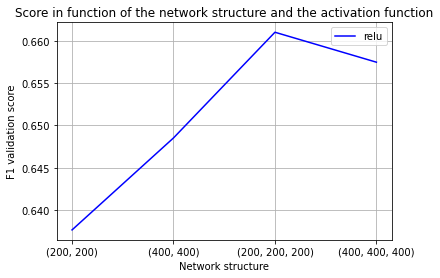

In [16]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
def select_neural_network(structures=[(200,200,),(400,400,), (200, 200, 200,), (400,400,400)], fit_per_step=1, multiclass='binary'):
    val_scores = np.zeros(len(structures))
    val_scores2 = np.zeros(len(structures))
    val_scores3 = np.zeros(len(structures))
    for i, structure in enumerate(structures):
        print(i, end=' ')
        for _ in range(fit_per_step):
            NN = MLPClassifier(hidden_layer_sizes=structure, learning_rate_init=0.01 if len(structure)==1 else 0.001, activation='relu', max_iter=60)
            cross_val = cross_validate(NN, X_train, y_train, cv=5, scoring='f1_micro')
            val_scores[i] += statistics.mean(cross_val['test_score']) 
        val_scores[i] /= fit_per_step
        val_scores2[i] /= fit_per_step
        val_scores3[i] /= fit_per_step
    plt.figure()
    plt.plot([str(s) for s in structures], val_scores, 'blue', label='relu')
    plt.title('Score in function of the network structure and the activation function')
    plt.xlabel('Network structure')
    plt.ylabel('F1 validation score')
    plt.legend()
    plt.grid()
select_neural_network(multiclass='micro')

1 4 7 12 19 26 35 45 56 69 82 97 113 131 150 

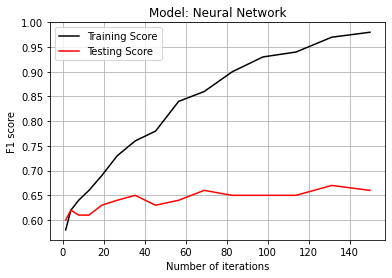

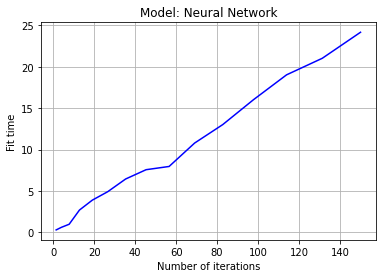

In [18]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
n = 15
I = 150*(np.linspace(0.1,1,n))**2
train_time = np.zeros(n)
train_score = np.zeros(n)
val_score = np.zeros(n)
for c,i in enumerate(I):
    print(int(i), end=' ')
    NN = MLPClassifier(hidden_layer_sizes=(200, 200), learning_rate_init=0.001, activation='relu', max_iter=int(i))
    t1 = time.time()
    NN.fit(X_train,y_train)
    t2 = time.time()
    train_time[c] = t2-t1
    train_score[c] = round(f1_score(NN.predict(X_train),y_train, average='micro'),2)
    val_score[c] = round(f1_score(NN.predict(X_test),y_test, average='micro'),2)
plt.figure()
plt.plot(I, train_score, 'black', label='Training Score')
plt.plot(I, val_score, 'red', label='Testing Score')
plt.title('Model: Neural Network')
plt.xlabel('Number of iterations')
plt.ylabel('F1 score')
plt.legend()
plt.grid()

plt.figure()
plt.plot(I, train_time, 'blue')
plt.title('Model: Neural Network')
plt.xlabel('Number of iterations')
plt.ylabel('Fit time')
plt.grid()

In [7]:
DTC = tree.DecisionTreeClassifier(max_depth=17)
RFC = RandomForestClassifier(n_estimators=100, max_depth=20)
KNN = KNeighborsClassifier(n_neighbors=16, weights='distance', metric='euclidean')
SVM1 = svm.SVC(kernel='poly', degree=3)
SVM2 = svm.SVC(kernel='rbf', gamma=1)
NN = MLPClassifier(hidden_layer_sizes=(200, 200), learning_rate_init=0.001, activation='relu', max_iter=150)
models = [DTC,RFC,KNN,SVM1,SVM2,NN]

In [23]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
for model in models:
    print(model)
    t1 = time.time()
    model.fit(X_train,y_train)
    t2 = time.time()
    prediction = model.predict(X_test)
    t3 = time.time()
    print('fit time: ', round(1000*(t2-t1),3) , ' - prediction time: ', round(1000*(t3-t2), 3))
    print('f1 score: ', round(f1_score(prediction, y_test, average='micro'),2))

DecisionTreeClassifier(max_depth=17)
fit time:  45.488  - prediction time:  3.416
f1 score:  0.64
RandomForestClassifier(max_depth=20)
fit time:  703.165  - prediction time:  31.775
f1 score:  0.7
KNeighborsClassifier(metric='euclidean', n_neighbors=16, weights='distance')
fit time:  5.632  - prediction time:  74.235
f1 score:  0.69
SVC(kernel='poly')
fit time:  586.052  - prediction time:  61.112
f1 score:  0.57
SVC(gamma=1)
fit time:  879.891  - prediction time:  133.712
f1 score:  0.64
MLPClassifier(hidden_layer_sizes=(200, 200), max_iter=150)
fit time:  23547.699  - prediction time:  13.179
f1 score:  0.67
